In [1]:
import os

import vidgear.gears
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import PIL.Image
from ultralytics import YOLO
import numpy as np
import cv2
import easyocr
import matplotlib.pyplot as plt
import math
import PIL
import vidgear
import random
import time
import datetime
from wpodnet.backend import Predictor
from wpodnet.model import WPODNet
import torch
from PIL import Image
import multiprocessing as mp
import grpc
import math
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76
from collections import Counter
import webcolors

import protos.imgresize_pb2_grpc as imgresize_pb2_grpc
import protos.imgresize_pb2 as imgresize_pb2
import protos.yolov8_pb2_grpc as yolov8_pb2_grpc
import protos.yolov8_pb2 as yolov8_pb2
import protos.platecrop_pb2_grpc as platecrop_pb2_grpc
import protos.platecrop_pb2 as platecrop_pb2
import protos.ocr_pb2_grpc as ocr_pb2_grpc
import protos.ocr_pb2 as ocr_pb2
import protos.imgcolor_pb2_grpc as imgcolor_pb2_grpc
import protos.imgcolor_pb2 as imgcolor_pb2
import protos.types_pb2 as types_pb2

from utills import drawText, bts_to_img, image_to_bts, rgb_to_hex, closest_color

# yolo_model = YOLO(verbose=False)
# ocr_model = easyocr.Reader(["en","vi"], verbose=False, model_storage_directory=".")

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = WPODNet()
# model.to(device)
# checkpoint = torch.load('./wpodnet.pth')
# model.load_state_dict(checkpoint)
# wpod_model = Predictor(model)

IMGRESIZE_CHANNEL = "localhost:50051"
YOLO_CHANNEL = "localhost:50052"
PLATECROP_CHANNEL = "localhost:50053"
OCR_CHANNEL = "localhost:50054"
IMGCOLOR_CHANNEL = "localhost:50055"

imgresize_stub = imgresize_pb2_grpc.ImgResizeStub(
    grpc.insecure_channel(IMGRESIZE_CHANNEL)
)
yolo_stub = yolov8_pb2_grpc.Yolov8Stub(
    grpc.insecure_channel(YOLO_CHANNEL)
)
platecrop_stub = platecrop_pb2_grpc.PlateCropStub(
    grpc.insecure_channel(PLATECROP_CHANNEL)
)
ocr_stub = ocr_pb2_grpc.OcrStub(
    grpc.insecure_channel(OCR_CHANNEL)
)
imgcolor_stub = imgcolor_pb2_grpc.ImgColorStub(
    grpc.insecure_channel(IMGCOLOR_CHANNEL)
)

In [2]:
#Returns the colours in the image
def get_colours(img, no_of_colours:int=3, hex_output:bool=True):
    #Reduce the input to two dimensions for KMeans
    mod_img = img.reshape(img.shape[0]*img.shape[1], 3)

    #Define the clusters
    clf = KMeans(n_clusters = no_of_colours)
    labels = clf.fit_predict(mod_img)

    counts = Counter(labels)
    counts = dict(sorted(counts.items()))

    center_colours = clf.cluster_centers_
    ordered_colours = [center_colours[i] for i in counts.keys()]
    hex_colours = [rgb_to_hex(ordered_colours[i]) for i in counts.keys()]
    rgb_colours = [ordered_colours[i] for i in counts.keys()]
    output = None
    if hex_output:
        output=hex_colours
    else:
        output=rgb_colours
    return output

In [3]:
def VehicleDetect(img) -> list[dict]:
    # Resize to 480p ----> remote
    # Input  : <image> data=bytes,metadata=bytes
    # Output : <image> data=bytes,metadata=bytes
    (h, w) = img.shape[:2]
    # new_height = 480
    # aspect_ratio = w/h
    # new_width = int(new_height * aspect_ratio)
    # tmp_img = cv2.resize(img, (new_width, new_height))
    
    platecrop_response = imgresize_stub.To480p(types_pb2.Image(data=image_to_bts(img)))
    tmp_img = bts_to_img(platecrop_response.data)
    
    # Detect boxes & raw id ----> remote
    # Input  : <image> data=bytes,metadata=bytes
    # Output : <detectresult> x0=array[int],x1=array[int],y0=array[int],y1=array[int],id=array[string]    
    # detect_results = yolo_model.track(tmp_img, verbose=False)
    # boxes = detect_results[0].boxes
    # n_fig =len(boxes)
    # vehicles_box = []
    # vehicles_id = []
    # for box in boxes:
    #     x0, y0, x1, y1 = box.xyxyn[0]
    #     id = "#"
    #     if not (box.id is None):
    #         id = box.id[0]
    #     vehicles_id.append(f"{id}_{detect_results[0].names[int(round(box.cls[0].item()))]}")
    #     vehicles_box.append((x0, y0, x1, y1))
    platecrop_response = yolo_stub.Detect(types_pb2.Image(data=image_to_bts(tmp_img)))
    boxes = platecrop_response.boxes
    
    # Crop to boxes ----> local
    # vehicles_img = []
    # vehicles_box_org = []
    # for box in vehicles_box:
    #     x0, y0, x1, y1 = box
    #     x0 = int(x0*w)
    #     x1 = int(x1*w)
    #     y0 = int(y0*h)
    #     y1 = int(y1*h)
    #     cropped = img[y0:y1,x0:x1]
    #     vehicles_img.append(cropped)
    #     vehicles_box_org.append((x0, y0, x1, y1))
    box_ids = []
    box_imgs = []
    box_org = []
    for box in boxes:
        x0 = int(math.floor(box.x0 * w))
        y0 = int(math.floor(box.y0 * h))
        x1 = int(math.ceil(box.x1 * w))
        y1 = int(math.ceil(box.y1 * h))
        id = box.id
        if x1 < x0:
            x0, x1 = x1, x0
        if y1 < y0:
            y0, y1 = y1, y0
        cropped = img[y0:y1,x0:x1]
        box_ids.append(id)
        box_imgs.append(cropped)
        # print(cropped,id)
        box_org.append((x0,y0,x1,y1))    
    # Extract plates (if possible) ----> remote
    # Input  : <image> data=bytes,metadata=bytes
    # Output : <image> data=bytes,metadata=bytes
    # plates = []
    # for v_img in vehicles_img:
    #     prediction = wpod_model.predict(Image.fromarray(np.uint8(v_img)).convert('RGB'))
    #     wrapped = prediction.warp()
    #     if prediction.confidence > 0.9:
    #         plates.append(np.array(wrapped))
    #     else:
    #         plates.append(v_img)
    plate_imgs = []
    box_colors = []
    for box_img in box_imgs:
        # print(box_img)
        request_img = types_pb2.Image(data=image_to_bts(box_img))
        platecrop_response = platecrop_stub.Crop(request_img)
        imgcolor_response = imgcolor_stub.GetPrimaryColors(request_img)
        plate_imgs.append(bts_to_img(platecrop_response.data))
        box_colors.append(",".join(list(imgcolor_response.text)))
    
    # Read text ----> remote
    # Input  : <image> data=bytes,metadata=bytes
    # Output : <string>
    # vehicles_iden = []
    # for v_img in plates:
    #     ocr_result = ocr_model.readtext(v_img, paragraph=True, detail=0)
    #     vehicles_iden.append("#&#".join(ocr_result)  if len(ocr_result) > 0 else "##&NOTEXT&##")
    vehicle_ids = []
    for plate_img in plate_imgs:
        platecrop_response = ocr_stub.ReadText(types_pb2.Image(data=image_to_bts(plate_img)))
        texts = platecrop_response.text
        vehicle_id = "#".join(texts)
        vehicle_ids.append(vehicle_id)
    
    # Result ----> local
    result = list()
    for i in range(len(boxes)):
        x0, y0, x1, y1 = box_org[i]
        result.append({
            "id":f"{box_ids[i]}_{box_colors[i]}_{vehicle_ids[i]}",
            "x0": x0, "x1": x1, "y0": y0, "y1": y1
        })
        
    return result

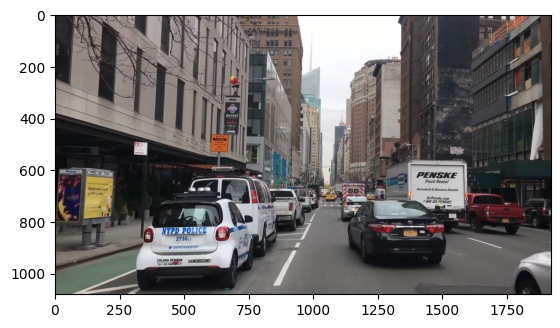

In [4]:
img = cv2.cvtColor(cv2.imread("./data/sample.png", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
for c in get_colours(img, 3):
    cl = closest_color(c)
    print(cl)

darkslategrey
grey
gainsboro


In [6]:
idens = VehicleDetect(img)
idens

[{'id': '1.0_car_darkslategrey,black,darkgrey_72525T',
  'x0': 1127,
  'x1': 1513,
  'y0': 713,
  'y1': 971},
 {'id': '2.0_car_dimgrey,lightgrey,black_510.000 REJHARD',
  'x0': 311,
  'x1': 767,
  'y0': 695,
  'y1': 1069},
 {'id': '3.0_car_lightgrey,black,dimgrey_',
  'x0': 1770,
  'x1': 1920,
  'y0': 914,
  'y1': 1080},
 {'id': '4.0_car_dimgrey,darkgrey,black_',
  'x0': 829,
  'x1': 962,
  'y0': 673,
  'y1': 837},
 {'id': '5.0_truck_silver,darkslategrey,dimgrey_PENSKE Truck Rental#Household & Business Rentals#GoPenske com 800-GO-PENSKE',
  'x0': 1273,
  'x1': 1593,
  'y0': 562,
  'y1': 827}]

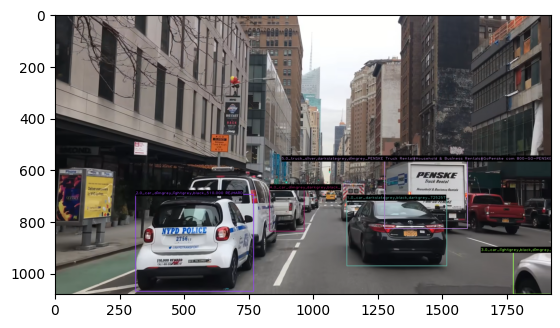

: 

In [8]:
frame = img
for iden in idens:
    color_code = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    cv2.rectangle(
        frame, 
        (iden["x0"], iden["y0"]), (iden["x1"], iden["y1"]), 
        color=color_code, 
        thickness=2
    )
    
    frame = drawText(
        frame, iden["id"],
        text_position=(iden["x0"], iden["y0"]), 
        text_color=color_code
    )

plt.imshow(frame)